In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Other Computer Vision Problems

In the previous chapter you learned some important practical techniques for training models in practice. Considerations like selecting learning rates and the number of epochs are very important to getting good results.

In this chapter we are going to look at two other types of computer vision problems: multi-label classification and regression. The first one is when you want to predict more than one label per image (or sometimes none at all), and the second is when your labels are one or several numbers—a quantity instead of a category.

In the process will study more deeply the output activations, targets, and loss functions in deep learning models.

## Multi-Label Classification

Multi-label classification refers to the problem of identifying the categories of objects in images that may not contain exactly one type of object. There may be more than one kind of object, or there may be no objects at all in the classes that you are looking for.

For instance, this would have been a great approach for our bear classifier. One problem with the bear classifier that we rolled out in <<chapter_production>> was that if a user uploaded something that wasn't any kind of bear, the model would still say it was either a grizzly, black, or teddy bear—it had no ability to predict "not a bear at all." In fact, after we have completed this chapter, it would be a great exercise for you to go back to your image classifier application, and try to retrain it using the multi-label technique, then test it by passing in an image that is not of any of your recognized classes.

In practice, we have not seen many examples of people training multi-label classifiers for this purpose—but we very often see both users and developers complaining about this problem. It appears that this simple solution is not at all widely understood or appreciated! Because in practice it is probably more common to have some images with zero matches or more than one match, we should probably expect in practice that multi-label classifiers are more widely applicable than single-label classifiers.

First, let's see what a multi-label dataset looks like, then we'll explain how to get it ready for our model. You'll see that the architecture of the model does not change from the last chapter; only the loss function does. Let's start with the data.

### The Data

For our example we are going to use the PASCAL dataset, which can have more than one kind of classified object per image.

We begin by downloading and extracting the dataset as per usual:

In [3]:
from fastai.vision.all import *
# path = untar_data(URLs.PASCAL_2007)
path = Path('/storage/data/pascal_2007')

This dataset is different from the ones we have seen before, in that it is not structured by filename or folder but instead comes with a CSV (comma-separated values) file telling us what labels to use for each image. We can inspect the CSV file by reading it into a Pandas DataFrame:

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


As you can see, the list of categories in each image is shown as a space-delimited string.

### Sidebar: Pandas and DataFrames

No, it’s not actually a panda! *Pandas* is a Python library that is used to manipulate and analyze tabular and time series data. The main class is `DataFrame`, which represents a table of rows and columns. You can get a DataFrame from a CSV file, a database table, Python dictionaries, and many other sources. In Jupyter, a DataFrame is output as a formatted table, as shown here.

You can access rows and columns of a DataFrame with the `iloc` property, as if it were a matrix:

In [6]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [7]:
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

You can also grab a column by name by indexing into a DataFrame directly:

In [8]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

You can create new columns and do calculations using columns:

In [13]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [14]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


Pandas is a fast and flexible library, and an important part of every data scientist’s Python toolbox. Unfortunately, its API can be rather confusing and surprising, so it takes a while to get familiar with it. If you haven’t used Pandas before, we’d suggest going through a tutorial; we are particularly fond of the book [*Python for Data Analysis*](http://shop.oreilly.com/product/0636920023784.do) by Wes McKinney, the creator of Pandas (O'Reilly). It also covers other important libraries like `matplotlib` and `numpy`. We will try to briefly describe Pandas functionality we use as we come across it, but will not go into the level of detail of McKinney’s book.

### End sidebar

Now that we have seen what the data looks like, let's make it ready for model training.

### Constructing a DataBlock

How do we convert from a `DataFrame` object to a `DataLoaders` object? We generally suggest using the data block API for creating a `DataLoaders` object, where possible, since it provides a good mix of flexibility and simplicity. Here we will show you the steps that we take to use the data blocks API to construct a `DataLoaders` object in practice, using this dataset as an example.

As we have seen, PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

- `Dataset`:: A collection that returns a tuple of your independent and dependent variable for a single item
- `DataLoader`:: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables

On top of these, fastai provides two classes for bringing your training and validation sets together:

- `Datasets`:: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`:: An object that contains a training `DataLoader` and a validation `DataLoader`

Since a `DataLoader` builds on top of a `Dataset` and adds additional functionality to it (collating multiple items into a mini-batch), it’s often easiest to start by creating and testing `Datasets`, and then look at `DataLoaders` after that’s working.

When we create a `DataBlock`, we build up gradually, step by step, and use the notebook to check our data along the way. This is a great way to make sure that you maintain momentum as you are coding, and that you keep an eye out for any problems. It’s easy to debug, because you know that if a problem arises, it is in the line of code you just typed!

Let’s start with the simplest case, which is a data block created with no parameters:

In [5]:
dblock = DataBlock()

In [6]:
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


In [19]:
# df.index[df['is_valid']].tolist()
type(df.iloc[0])

pandas.core.series.Series

In [9]:
def get_x(x): return path/'train'/x['fname']
def get_y(y): return y['labels'].split()

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)

In [25]:
dsets.train[0]
# torch.where()

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [23]:
type(dsets.train.vocab)

fastai.data.transforms.CategoryMap

In [16]:
dsets.train.vocab[torch.where(dsets.train[0][1] == 1.)[0]],

((#2) ['car','person'],)

We can create a `Datasets` object from this. The only thing needed is a source—in this case, our DataFrame:

In [6]:
dsets = dblock.datasets(df)

This contains a `train` and a `valid` dataset, which we can index into:

In [ ]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [17]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

As you can see, this simply returns a row of the DataFrame, twice. This is because by default, the data block assumes we have two things: input and target. We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing `get_x` and `get_y` functions:

In [18]:
x['fname']

'008663.jpg'

In [8]:
# dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
# dsets = dblock.datasets(df)
# dsets.train[0]

As you can see, rather than defining a function in the usual way, we are using Python’s `lambda` keyword. This is just a shortcut for defining and then referring to a function. The following more verbose approach is identical:

In [7]:
# def get_x(r): return r['fname']
# def get_y(r): return r['labels']
# dblock = DataBlock(get_x = get_x, get_y = get_y)
# dsets = dblock.datasets(df)
# dsets.train[0]

Lambda functions are great for quickly iterating, but they are not compatible with serialization, so we advise you to use the more verbose approach if you want to export your `Learner` after training (lambdas are fine if you are just experimenting).

We can see that the independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable will need to be split on the space character (which is the default for Python’s `split` function) so that it becomes a list:

In [10]:
# def get_x(r): return path/'train'/r['fname']
# def get_y(r): return r['labels'].split(' ')
# dblock = DataBlock(get_x = get_x, get_y = get_y)
# dsets = dblock.datasets(df)
# dsets.train[0]

To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those. We can use the same block types that we have used previously, with one exception: the `ImageBlock` will work fine again, because we have a path that points to a valid image, but the `CategoryBlock` is not going to work. The problem is that block returns a single integer, but we need to be able to have multiple labels for each item. To solve this, we use a `MultiCategoryBlock`. This type of block expects to receive a list of strings, as we have in this case, so let’s test it out:

In [11]:
# dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
#                    get_x = get_x, get_y = get_y)
# dsets = dblock.datasets(df)
# dsets.train[0]

As you can see, our list of categories is not encoded in the same way that it was for the regular `CategoryBlock`. In that case, we had a single integer representing which category was present, based on its location in our vocab. In this case, however, we instead have a list of zeros, with a one in any position where that category is present. For example, if there is a one in the second and fourth positions, then that means that vocab items two and four are present in this image. This is known as *one-hot encoding*. The reason we can’t easily just use a list of category indices is that each list would be a different length, and PyTorch requires tensors, where everything has to be the same length.

> jargon: One-hot encoding: Using a vector of zeros, with a one in each location that is represented in the data, to encode a list of integers.

Let’s check what the categories represent for this example (we are using the convenient `torch.where` function, which tells us all of the indices where our condition is true or false):

In [ ]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

With NumPy arrays, PyTorch tensors, and fastai’s `L` class, we can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

We have ignored the column `is_valid` up until now, which means that `DataBlock` has been using a random split by default. To explicitly choose the elements of our validation set, we need to write a function and pass it to `splitter` (or use one of fastai's predefined functions or classes). It will take the items (here our whole DataFrame) and must return two (or more) lists of integers:

In [12]:
# def splitter(df):
#     train = df.index[~df['is_valid']].tolist()
#     valid = df.index[df['is_valid']].tolist()
#     return train,valid

# dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
#                    splitter=splitter,
#                    get_x=get_x, 
#                    get_y=get_y)

# dsets = dblock.datasets(df)
# dsets.train[0]

As we have discussed, a `DataLoader` collates the items from a `Dataset` into a mini-batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. 

Now that we have confirmed that the individual items look okay, there's one more step we need to ensure we can create our `DataLoaders`, which is to ensure that every item is of the same size. To do this, we can use `RandomResizedCrop`:

In [13]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

And now we can display a sample of our data:

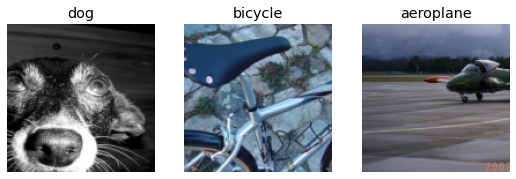

In [14]:
dls.show_batch(nrows=1, ncols=3)

Remember that if anything goes wrong when you create your `DataLoaders` from your `DataBlock`, or if you want to view exactly what happens with your `DataBlock`, you can use the `summary` method we presented in the last chapter.

Our data is now ready for training a model. As we will see, nothing is going to change when we create our `Learner`, but behind the scenes, the fastai library will pick a new loss function for us: binary cross-entropy.

### Binary Cross-Entropy

Now we'll create our `Learner`. We saw in <<chapter_mnist_basics>> that a `Learner` object contains four main things: the model, a `DataLoaders` object, an `Optimizer`, and the loss function to use. We already have our `DataLoaders`, we can leverage fastai's `resnet` models (which we'll learn how to create from scratch later), and we know how to create an `SGD` optimizer. So let's focus on ensuring we have a suitable loss function. To do this, let's use `cnn_learner` to create a `Learner`, so we can look at its activations:

In [ ]:
learn = cnn_learner(dls, resnet18)

We also saw that the model in a `Learner` is generally an object of a class inheriting from `nn.Module`, and that we can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini-batch. We can try it out by grabbing a mini batch from our `DataLoader` and then passing it to the model:

In [ ]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

Think about why `activs` has this shape—we have a batch size of 64, and we need to calculate the probability of each of 20 categories. Here’s what one of those activations looks like:

In [ ]:
activs[0]

TensorImage([ 0.7476, -1.1988,  4.5421, -1.5915, -0.6749,  0.0343, -2.4930, -0.8330, -0.3817, -1.4876, -0.1683,  2.1547, -3.4151, -1.1743,  0.1530, -1.6801, -2.3067,  0.7063, -1.3358, -0.3715],
       grad_fn=<AliasBackward>)

> note: Getting Model Activations: Knowing how to manually get a mini-batch and pass it into a model, and look at the activations and loss, is really important for debugging your model. It is also very helpful for learning, so that you can see exactly what is going on.

They aren’t yet scaled to between 0 and 1, but we learned how to do that in <<chapter_mnist_basics>>, using the `sigmoid` function. We also saw how to calculate a loss based on this—this is our loss function from <<chapter_mnist_basics>>, with the addition of `log` as discussed in the last chapter:

In [ ]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax`, as we saw, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others (due to the use of `exp`); however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be *less* than 1, if we don't think *any* of the categories appear in an image.
- `nll_loss`, as we saw, returns the value of just one activation: the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the other hand, the `binary_cross_entropy` function, which is just `mnist_loss` along with `log`, provides just what we need, thanks to the magic of PyTorch's elementwise operations. Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns.

> j: One of the things I really like about working with libraries like PyTorch, with broadcasting and elementwise operations, is that quite frequently I find I can write code that works equally well for a single item or a batch of items, without changes. `binary_cross_entropy` is a great example of this. By using these operations, we don't have to write loops ourselves, and can rely on PyTorch to do the looping we need as appropriate for the rank of the tensors we're working with.

PyTorch already provides this function for us. In fact, it provides a number of versions, with rather confusing names!

`F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial `sigmoid`. Normally for one-hot-encoded targets you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function, as in the preceding example.

The equivalent for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use `BCEWithLogitsLoss`:

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorImage(1.0342, grad_fn=<AliasBackward>)

We don't actually need to tell fastai to use this loss function (although we can if we want) since it will be automatically chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

One change compared to the last chapter is the metric we use: because this is a multilabel problem, we can't use the accuracy function. Why is that? Well, accuracy was comparing our outputs to our targets like so:

```python
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()
```

The class predicted was the one with the highest activation (this is what `argmax` does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0:

```python
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()
```

If we pass `accuracy_multi` directly as a metric, it will use the default value for `threshold`, which is 0.5. We might want to adjust that default and create a new version of `accuracy_multi` that has a different default. To help with this, there is a function in Python called `partial`. It allows us to *bind* a function with some arguments or keyword arguments, making a new version of that function that, whenever it is called, always includes those arguments. For instance, here is a simple function taking two arguments:

In [ ]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

We can switch to a French version of that function by using `partial`:

In [ ]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.942663,0.703737,0.233307,00:08
1,0.821548,0.550827,0.295319,00:08
2,0.604189,0.202585,0.816474,00:08
3,0.359258,0.123299,0.944283,00:08


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.135746,0.123404,0.944442,00:09
1,0.118443,0.107534,0.951255,00:09
2,0.098525,0.104778,0.951554,00:10


Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labeled objects. We can see this by changing our metric, and then calling `validate`, which returns the validation loss and metrics:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10477833449840546,0.9314740300178528]

If you pick a threshold that's too high, you'll only be selecting the objects for which your model is very confident:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10477833449840546,0.9429482221603394]

We can find the best threshold by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once:

In [ ]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it:

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorImage(0.9567)

We can now use this approach to find the best threshold level:

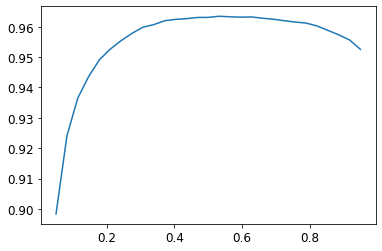

In [ ]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set. Sometimes students have expressed their concern that we might be *overfitting* to the validation set, since we're trying lots of values to see which is the best. However, as you see in the plot, changing the threshold in this case results in a smooth curve, so we're clearly not picking some inappropriate outlier. This is a good example of where you have to be careful of the difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) versus practice (if the relationship is smooth, then it's fine to do this).

This concludes the part of this chapter dedicated to multi-label classification. Next, we'll take a look at a regression problem.

## Regression

It's easy to think of deep learning models as being classified into domains, like *computer vision*, *NLP*, and so forth. And indeed, that's how fastai classifies its applications—largely because that's how most people are used to thinking of things.

But really, that's hiding a more interesting and deeper perspective. A model is defined by its independent and dependent variables, along with its loss function. That means that there's really a far wider array of models than just the simple domain-based split. Perhaps we have an independent variable that's an image, and a dependent that's text (e.g., generating a caption from an image); or perhaps we have an independent variable that's text and dependent that's an image (e.g., generating an image from a caption—which is actually possible for deep learning to do!); or perhaps we've got images, texts, and tabular data as independent variables, and we're trying to predict product purchases... the possibilities really are endless.

To be able to move beyond fixed applications, to crafting your own novel solutions to novel problems, it helps to really understand the data block API (and maybe also the mid-tier API, which we'll see later in the book). As an example, let's consider the problem of *image regression*. This refers to learning from a dataset where the independent variable is an image, and the dependent variable is one or more floats. Often we see people treat image regression as a whole separate application—but as you'll see here, we can treat it as just another CNN on top of the data block API.

We're going to jump straight to a somewhat tricky variant of image regression, because we know you're ready for it! We're going to do a key point model. A *key point* refers to a specific location represented in an image—in this case, we'll use images of people and we'll be looking for the center of the person's face in each image. That means we'll actually be predicting *two* values for each image: the row and column of the face center. 

### Assemble the Data

We will use the [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html) for this section. We'll begin by downloading the dataset as usual:

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [ ]:
#hide
Path.BASE_PATH = path

Let's see what we've got!

In [ ]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding *.obj* file for each (we won't need them here). Let's take a look inside one of these directories:

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Inside the subdirectories, we have different frames, each of them come with an image (*\_rgb.jpg*) and a pose file (*\_pose.txt*). We can easily get all the image files recursively with `get_image_files`, then write a function that converts an image filename to its associated pose file:

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('13/frame_00349_pose.txt')

Let's take a look at our first image:

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

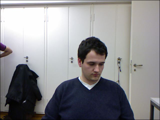

In [ ]:
im.to_thumb(160)

The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point:

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [ ]:
get_ctr(img_files[0])

tensor([384.6370, 259.4787])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference from the previous data block examples is that the second block is a `PointBlock`. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_transforms(size=(240,320)), 
)

> important: Points and Data Augmentation: We're not aware of other libraries (except for fastai) that automatically and correctly apply data augmentation to coordinates. So, if you're working with another library, you may need to disable data augmentation for these kinds of problems.

Before doing any modeling, we should look at our data to confirm it seems okay:

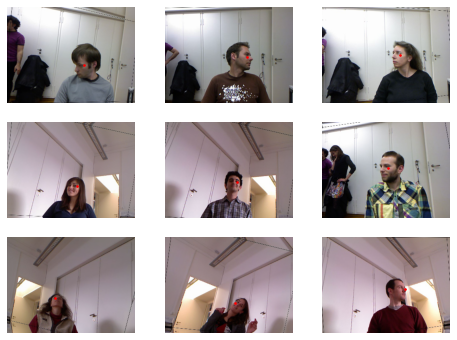

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

That's looking good! As well as looking at the batch visually, it's a good idea to also look at the underlying tensors (especially as a student; it will help clarify your understanding of what your model is really seeing):

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Make sure that you understand *why* these are the shapes for our mini-batches.

Here's an example of one row from the dependent variable:

In [ ]:
yb[0]

TensorPoint([[-0.3375,  0.2193]], device='cuda:6')

As you can see, we haven't had to use a separate *image regression* application; all we've had to do is label the data, and tell fastai what kinds of data the independent and dependent variables represent.

It's the same for creating our `Learner`. We will use the same function as before, with one new parameter, and we will be ready to train our model.

### Training a Model

As usual, we can use `cnn_learner` to create our `Learner`. Remember way back in <<chapter_intro>> how we used `y_range` to tell fastai the range of our targets? We'll do the same here (coordinates in fastai and PyTorch are always rescaled between -1 and +1):

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

`y_range` is implemented in fastai using `sigmoid_range`, which is defined as:

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

This is set as the final layer of the model, if `y_range` is defined. Take a moment to think about what this function does, and why it forces the model to output activations in the range `(lo,hi)`.

Here's what it looks like:

/home/jhoward/anaconda3/lib/python3.7/site-packages/fastbook/__init__.py:55: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


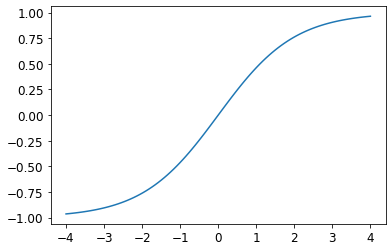

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since when coordinates are used as the dependent variable, most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `cnn_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.033113110810518265)

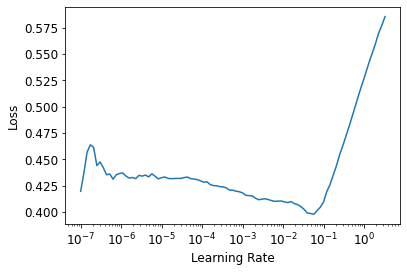

In [ ]:
learn.lr_find()

We'll try an LR of 1e-2:

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.049630,0.007602,00:42


epoch,train_loss,valid_loss,time
0,0.008714,0.004291,00:53
1,0.003213,0.000715,00:53
2,0.001482,0.000036,00:53


Generally when we run this we get a loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [ ]:
math.sqrt(0.0001)

0.01

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

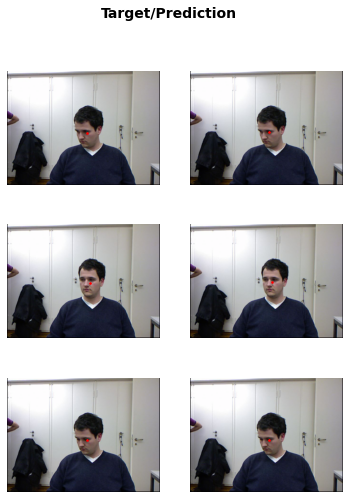

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

It's quite amazing that with just a few minutes of computation we've created such an accurate key points model, and without any special domain-specific application. This is the power of building on flexible APIs, and using transfer learning! It's particularly striking that we've been able to use transfer learning so effectively even between totally different tasks; our pretrained model was trained to do image classification, and we fine-tuned for image regression.

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.